In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [3]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5', '0.75')#, '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 120000
tok_type = "sp-unigram-merged"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram-merged", multil_string, f"alpha-{alpha}_N-120000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram-merged", multil_string, f"alpha-{alpha}_N-120000", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [4]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

In [5]:
len(overall_token_dists['0.0'])

120000

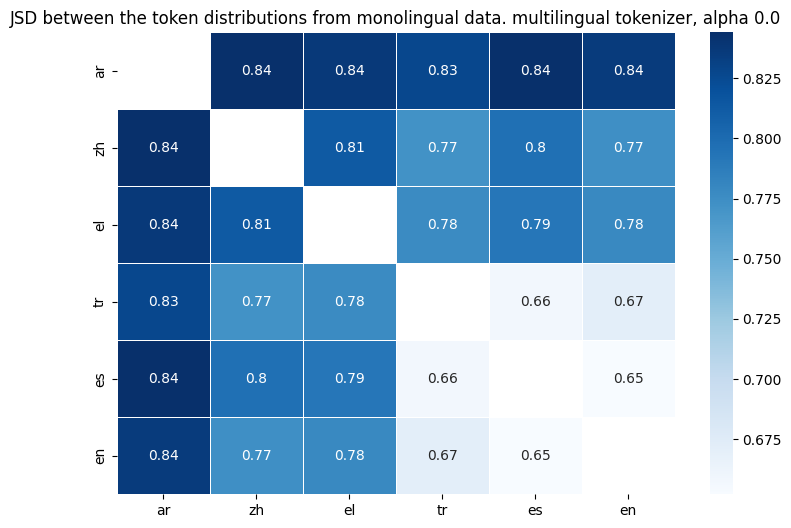

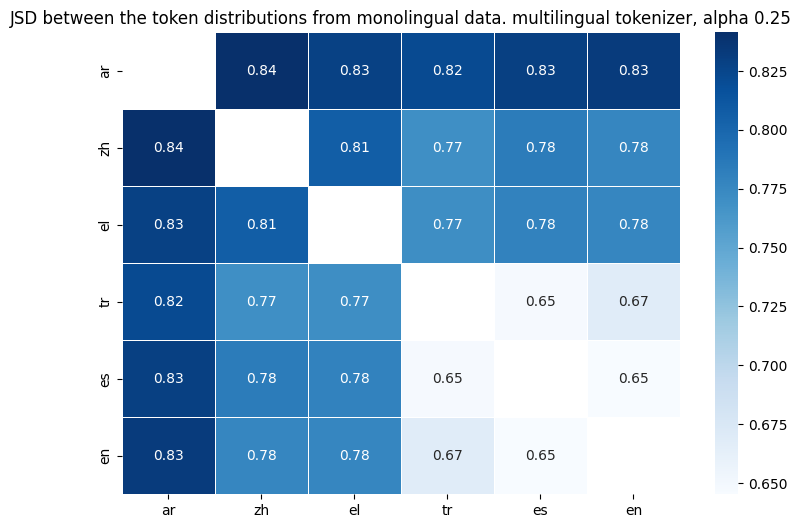

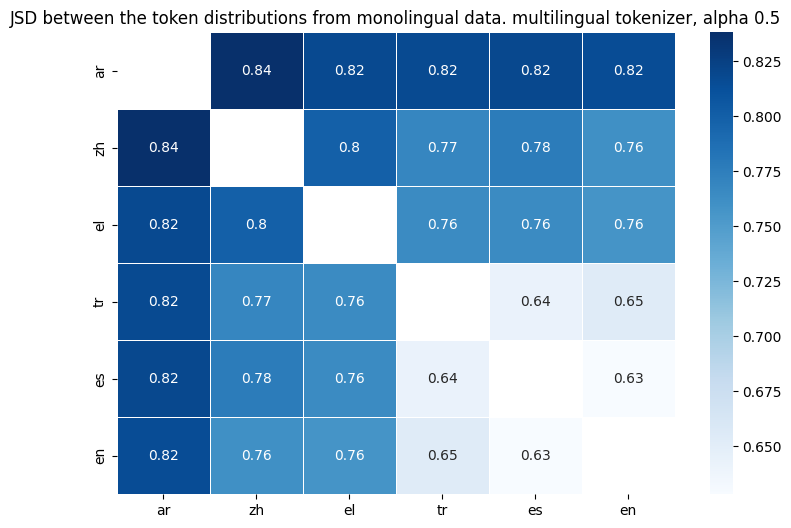

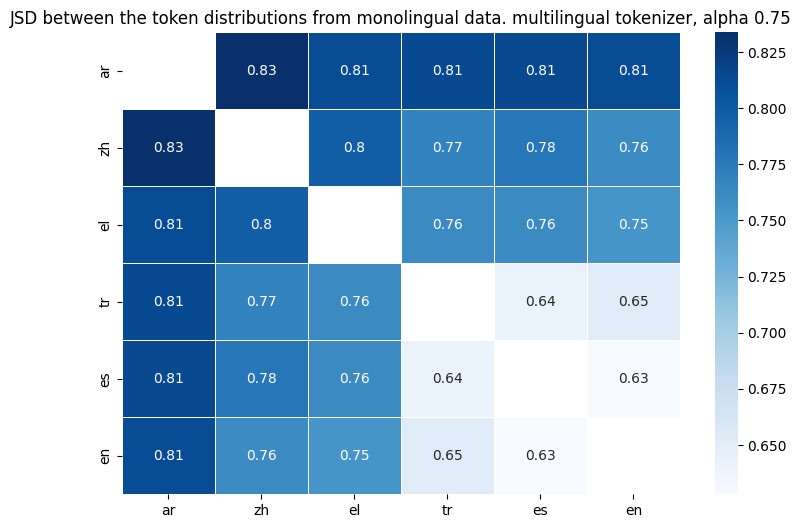

In [6]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2], base=2.) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

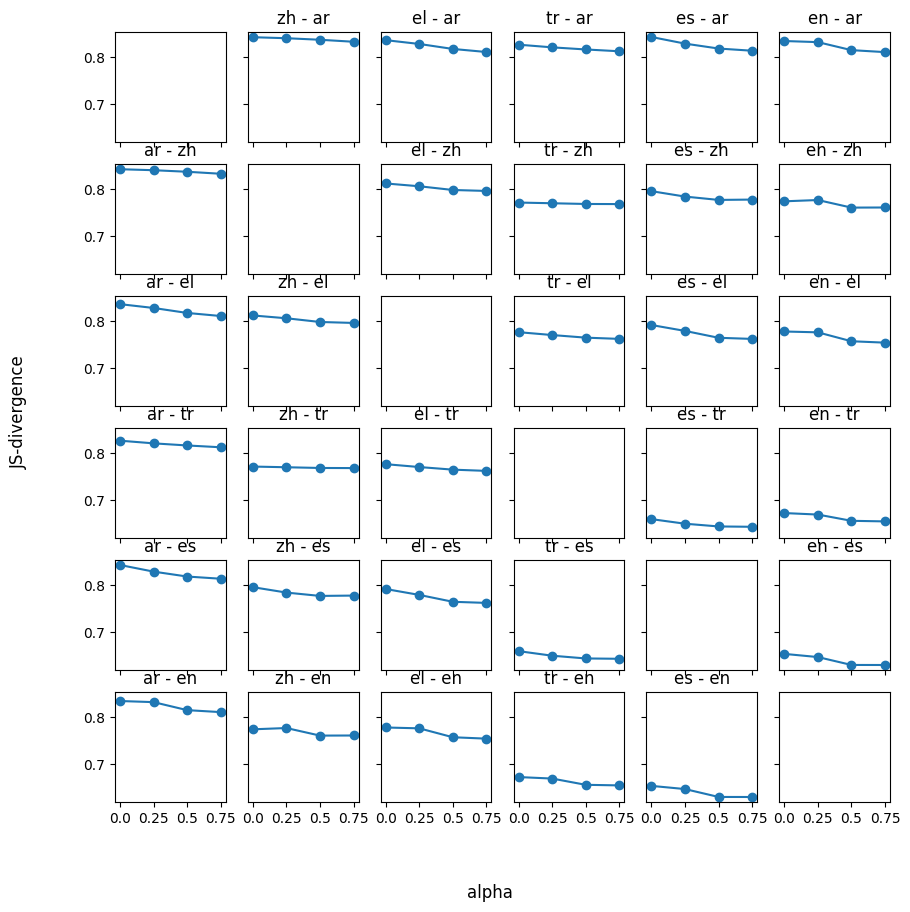

In [7]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


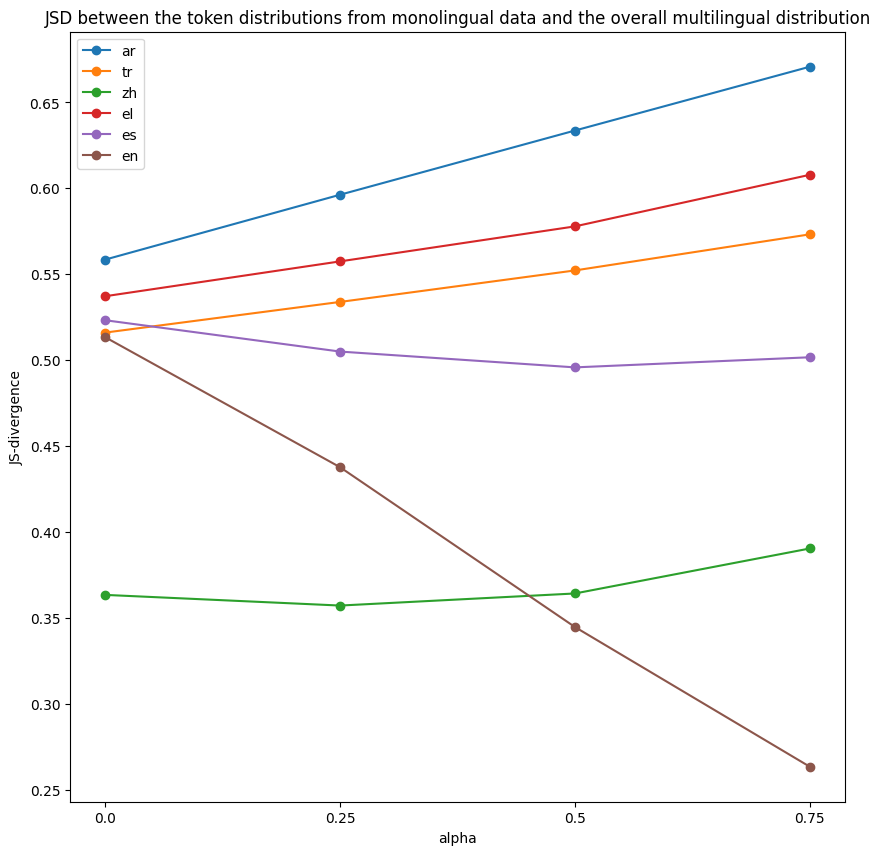

In [8]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

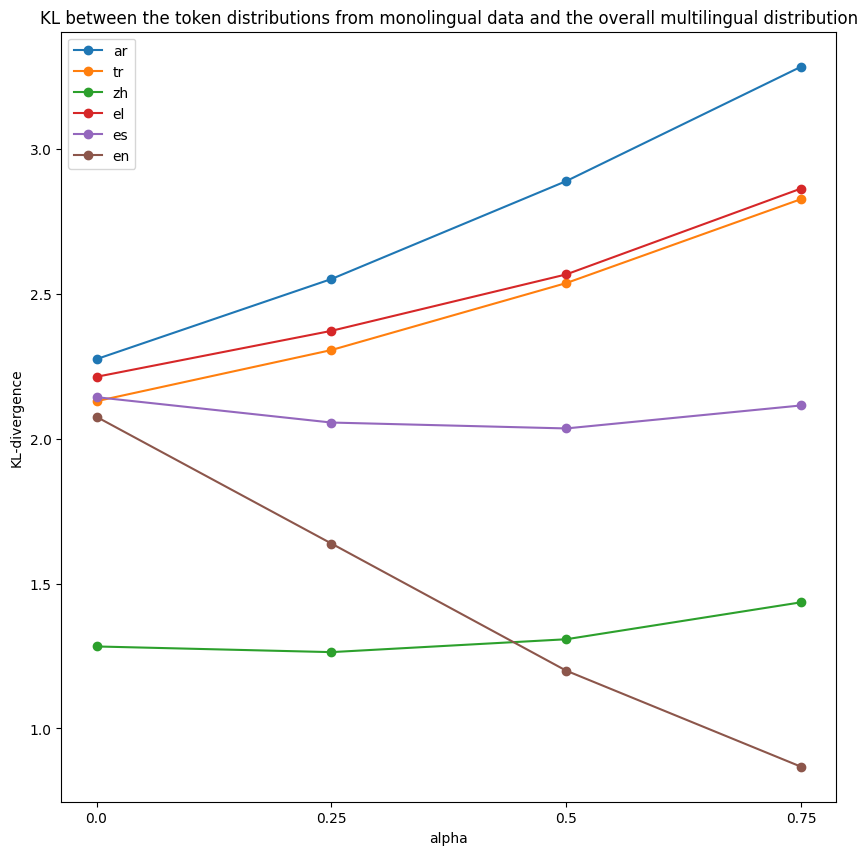

In [9]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha], base=2.)

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

# Tokenizer profile plot PDFs



<Figure size 640x480 with 0 Axes>

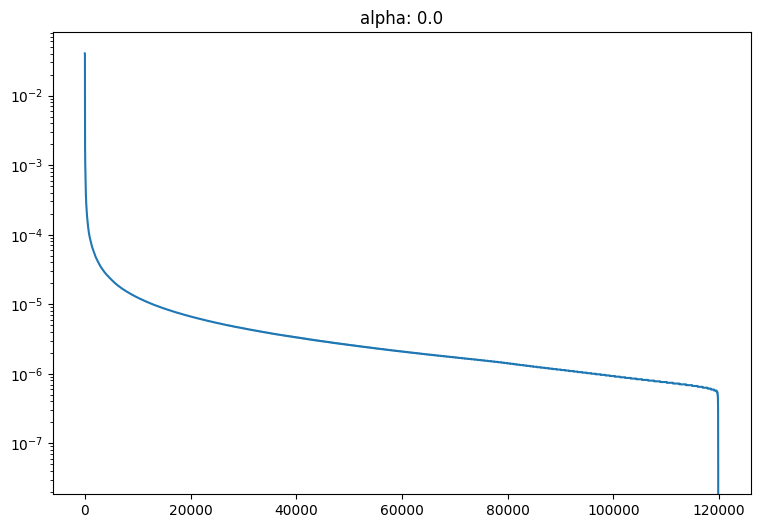

<Figure size 640x480 with 0 Axes>

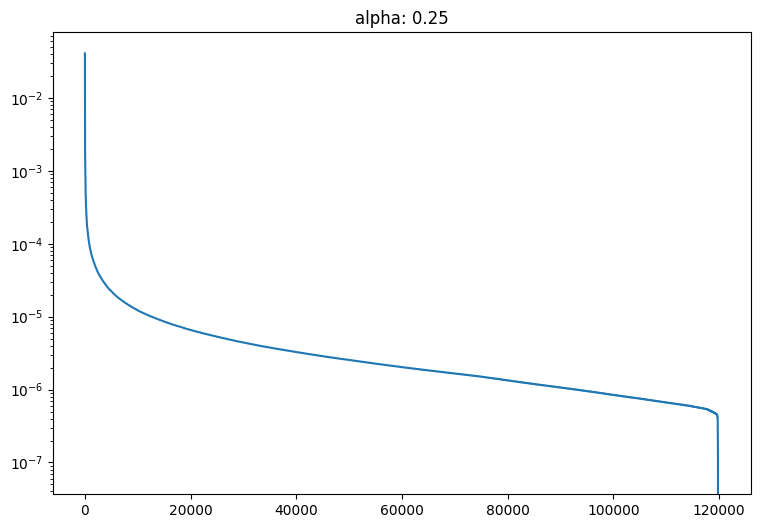

<Figure size 640x480 with 0 Axes>

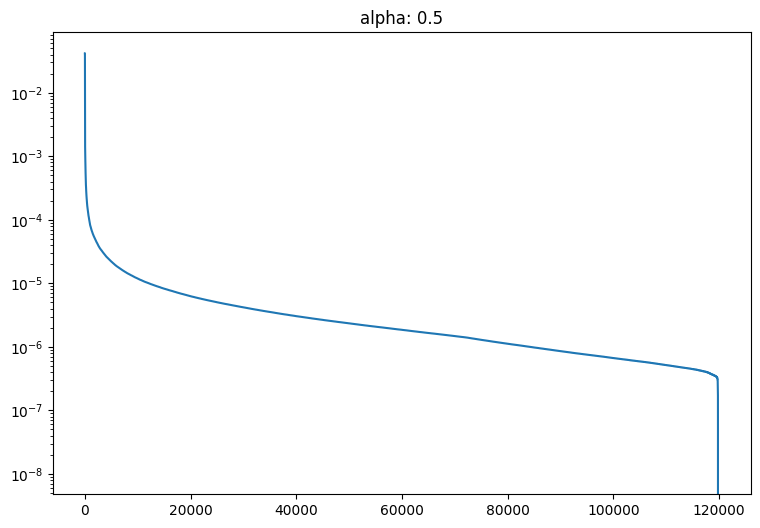

<Figure size 640x480 with 0 Axes>

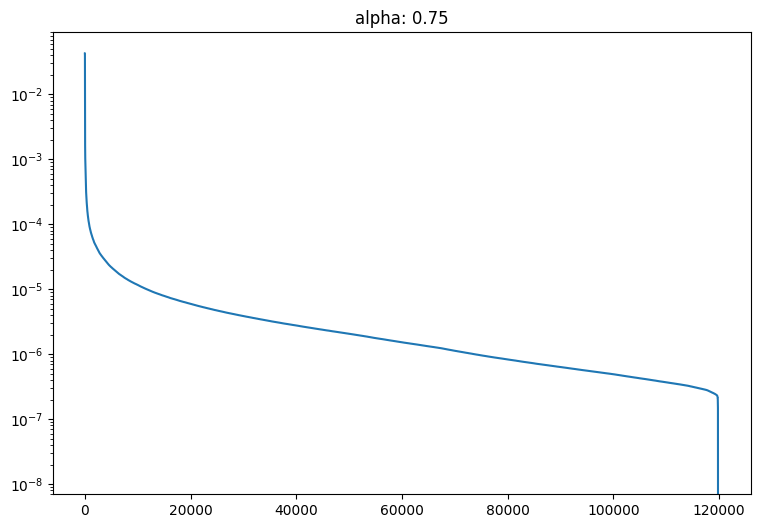

In [10]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(sorted_data)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    plt.show()


# For each language

<Figure size 640x480 with 0 Axes>

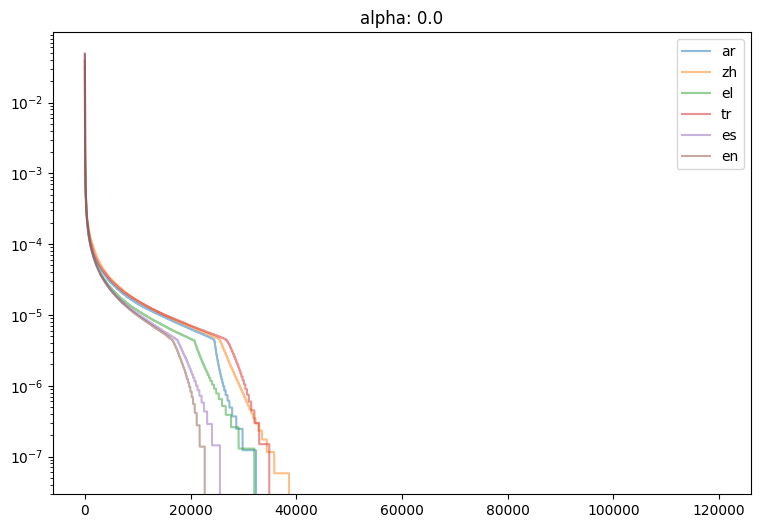

<Figure size 640x480 with 0 Axes>

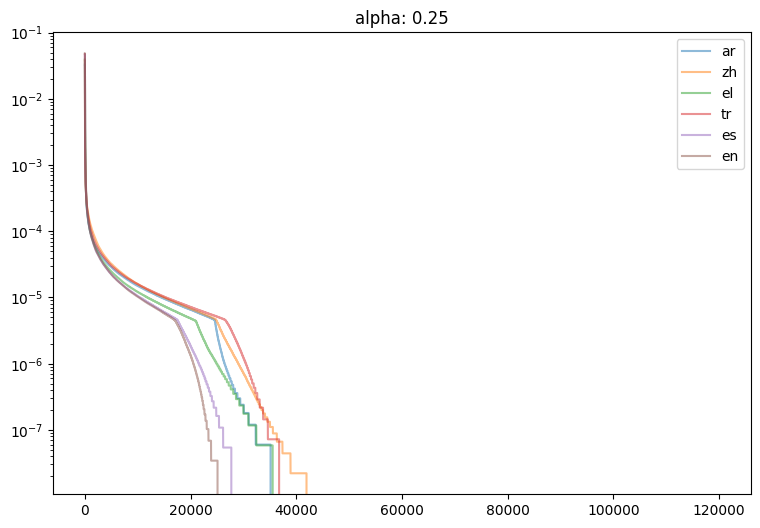

<Figure size 640x480 with 0 Axes>

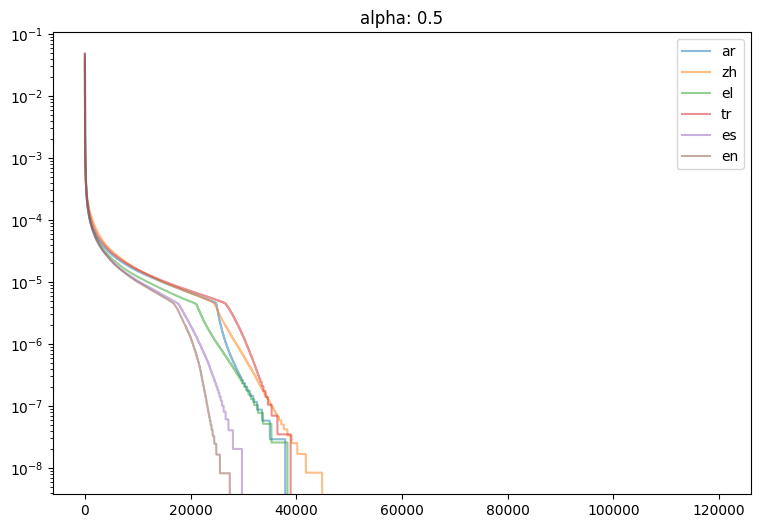

<Figure size 640x480 with 0 Axes>

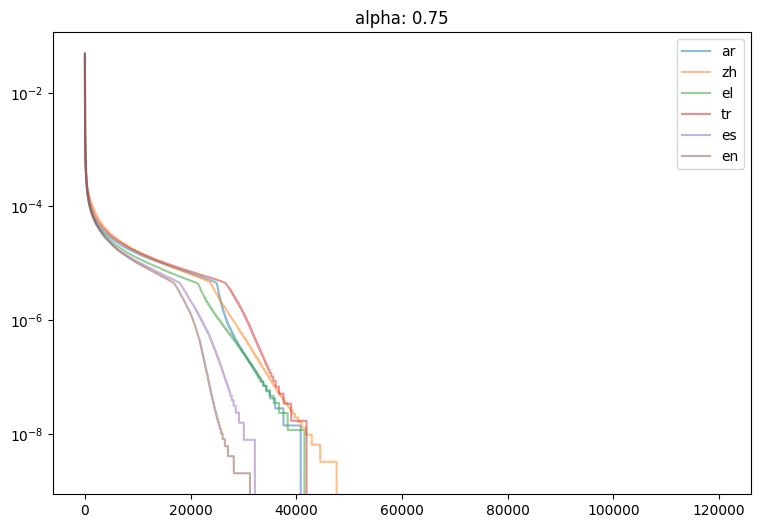

In [11]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(sorted_data, label=lang, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()

        

# CDFs

<Figure size 640x480 with 0 Axes>

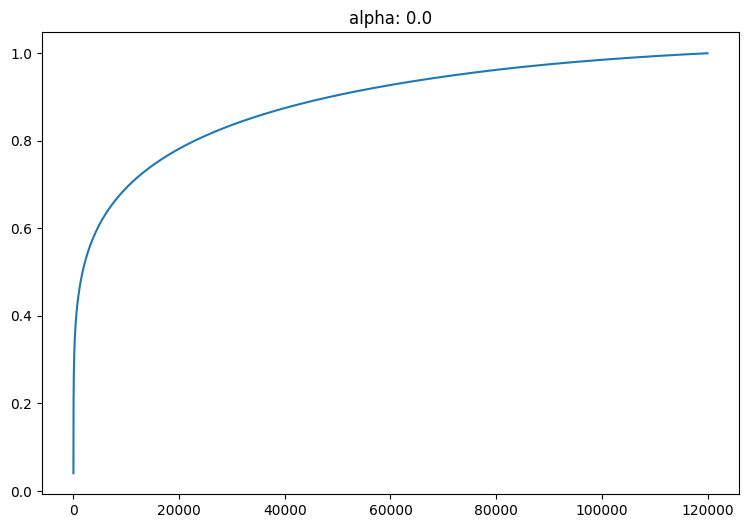

quatniles: 0.90, 0.95, 0.99, 0.999: [48384, 72096, 105630, 118099]
average rank: 13727


<Figure size 640x480 with 0 Axes>

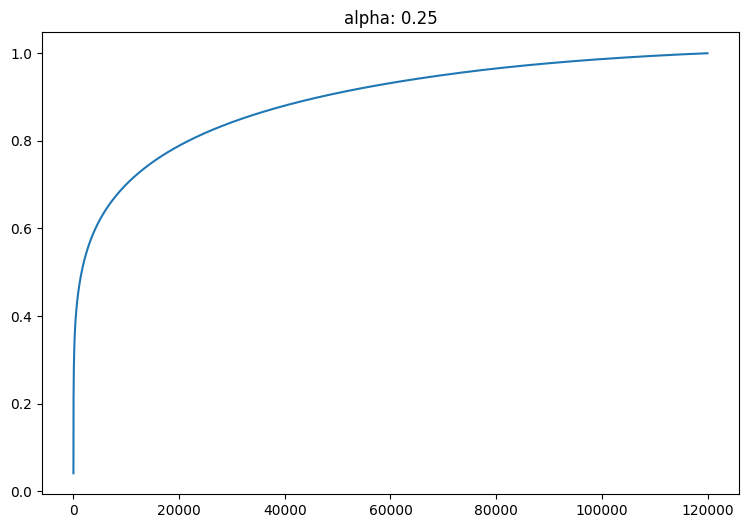

quatniles: 0.90, 0.95, 0.99, 0.999: [46503, 69787, 103963, 117750]
average rank: 13187


<Figure size 640x480 with 0 Axes>

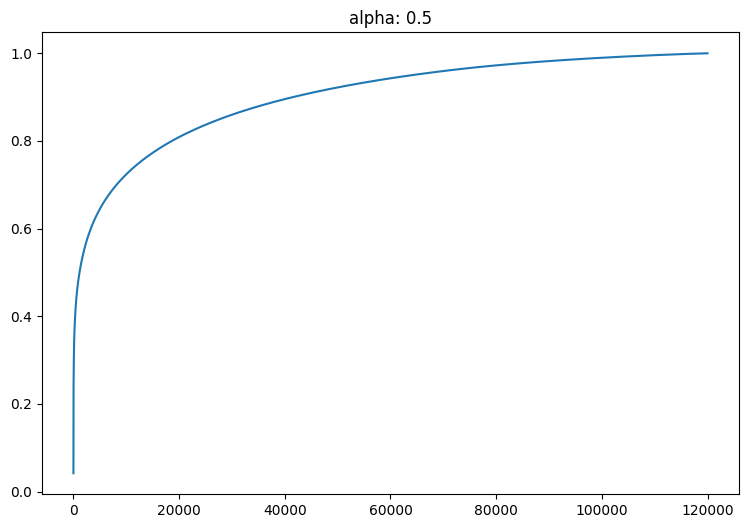

quatniles: 0.90, 0.95, 0.99, 0.999: [41530, 63989, 100311, 117108]
average rank: 11809


<Figure size 640x480 with 0 Axes>

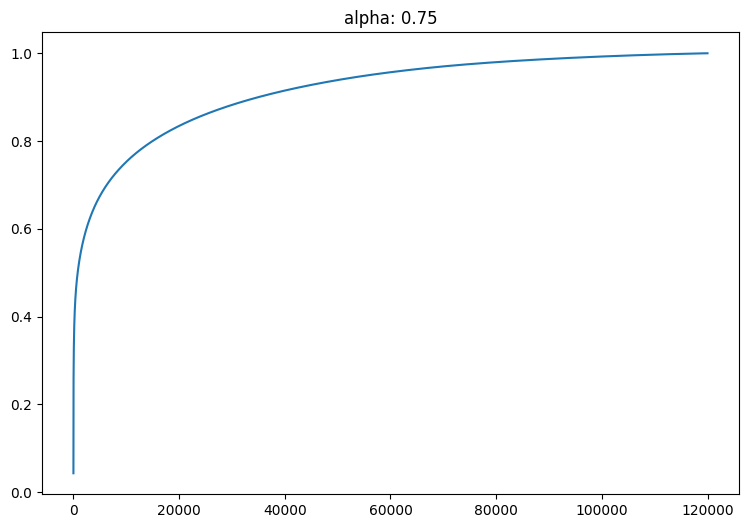

quatniles: 0.90, 0.95, 0.99, 0.999: [34977, 55800, 94927, 116097]
average rank: 10117


In [12]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    sorted_data = np.sort(overall_token_dists[alpha])[::-1]
    ax.plot(np.cumsum(sorted_data))

    ax.set_title(f"alpha: {alpha}")
    plt.show()
    

    
    percentile_idx = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
    avg_rang = np.sum(sorted_data * np.arange(len(sorted_data)))
    print(f"quatniles: 0.90, 0.95, 0.99, 0.999: {percentile_idx}")
    print(f"average rank: {np.round(avg_rang):.0f}")

<Figure size 640x480 with 0 Axes>

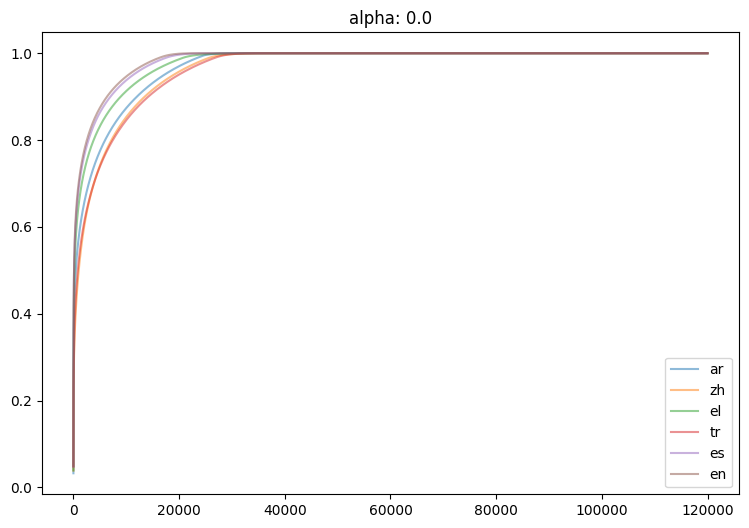

ar percentiles: 0.90, 0.95, 0.99, 0.999: [11999, 17130, 23549, 27640]
ar average rang: 3383
zh percentiles: 0.90, 0.95, 0.99, 0.999: [13482, 18908, 25787, 31718]
zh average rang: 4028
el percentiles: 0.90, 0.95, 0.99, 0.999: [8933, 13927, 20840, 27007]
el average rang: 2488
tr percentiles: 0.90, 0.95, 0.99, 0.999: [14158, 19845, 26868, 31169]
tr average rang: 4126
es percentiles: 0.90, 0.95, 0.99, 0.999: [6997, 11273, 17583, 22071]
es average rang: 1952
en percentiles: 0.90, 0.95, 0.99, 0.999: [6346, 10357, 16343, 19949]
en average rang: 1780


<Figure size 640x480 with 0 Axes>

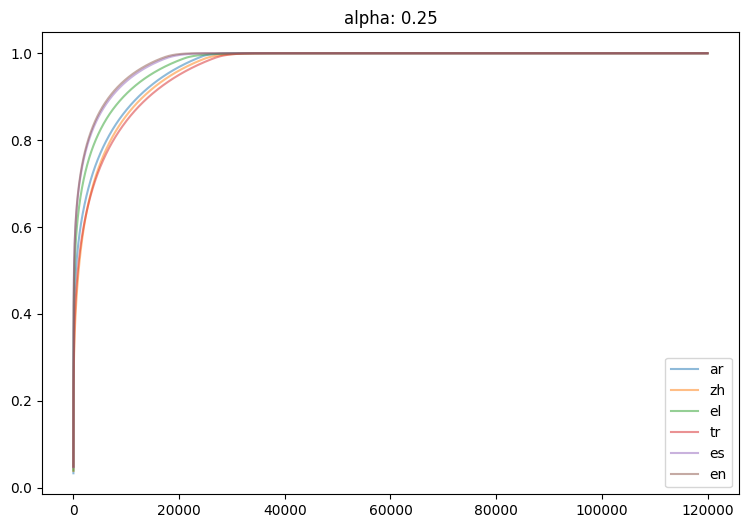

ar percentiles: 0.90, 0.95, 0.99, 0.999: [12311, 17419, 23769, 28345]
ar average rang: 3485
zh percentiles: 0.90, 0.95, 0.99, 0.999: [13223, 18558, 25417, 31929]
zh average rang: 3961
el percentiles: 0.90, 0.95, 0.99, 0.999: [9481, 14492, 21390, 28243]
el average rang: 2639
tr percentiles: 0.90, 0.95, 0.99, 0.999: [14287, 19939, 26921, 31581]
tr average rang: 4167
es percentiles: 0.90, 0.95, 0.99, 0.999: [7215, 11538, 17877, 22741]
es average rang: 1999
en percentiles: 0.90, 0.95, 0.99, 0.999: [6806, 10945, 17028, 20829]
en average rang: 1898


<Figure size 640x480 with 0 Axes>

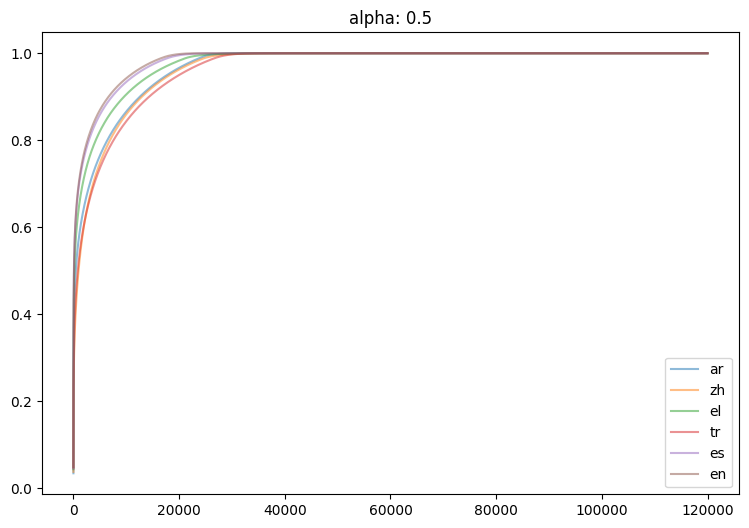

ar percentiles: 0.90, 0.95, 0.99, 0.999: [12554, 17715, 24078, 28887]
ar average rang: 3534
zh percentiles: 0.90, 0.95, 0.99, 0.999: [12941, 18203, 25061, 31814]
zh average rang: 3885
el percentiles: 0.90, 0.95, 0.99, 0.999: [9564, 14588, 21551, 28729]
el average rang: 2646
tr percentiles: 0.90, 0.95, 0.99, 0.999: [14307, 19987, 27019, 31864]
tr average rang: 4170
es percentiles: 0.90, 0.95, 0.99, 0.999: [7271, 11654, 18073, 23045]
es average rang: 2002
en percentiles: 0.90, 0.95, 0.99, 0.999: [6639, 10776, 16881, 20788]
en average rang: 1847


<Figure size 640x480 with 0 Axes>

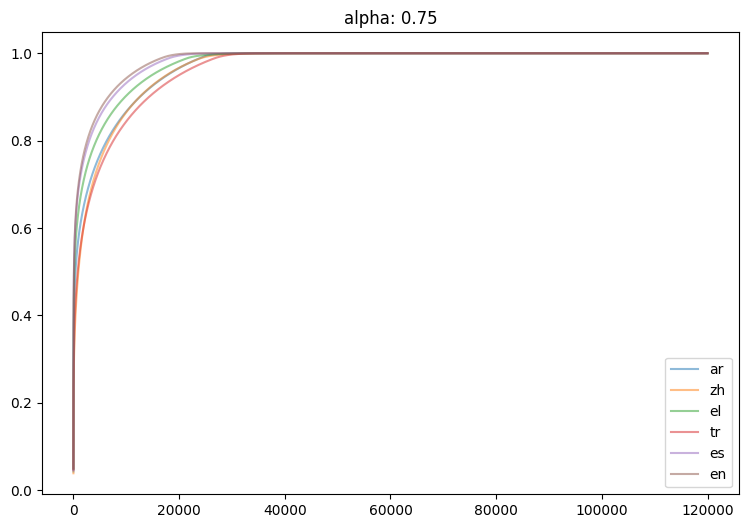

ar percentiles: 0.90, 0.95, 0.99, 0.999: [12551, 17759, 24171, 29270]
ar average rang: 3500
zh percentiles: 0.90, 0.95, 0.99, 0.999: [12508, 17620, 24408, 31227]
zh average rang: 3761
el percentiles: 0.90, 0.95, 0.99, 0.999: [9764, 14848, 21870, 29268]
el average rang: 2693
tr percentiles: 0.90, 0.95, 0.99, 0.999: [14295, 19975, 27062, 32209]
tr average rang: 4160
es percentiles: 0.90, 0.95, 0.99, 0.999: [7434, 11884, 18363, 23399]
es average rang: 2039
en percentiles: 0.90, 0.95, 0.99, 0.999: [6591, 10743, 16885, 20822]
en average rang: 1831


In [13]:
for alpha in alphas:
    plt.figure()
    f, ax = plt.subplots(figsize=(9, 6))
    percentile_idx = {}
    avg_rangs = {}
    for lang in languages:
        sorted_data = np.sort(token_dists[alpha][lang])[::-1]
        ax.plot(np.cumsum(sorted_data), label=lang, alpha=0.5)
        percentile_idx[lang] = [ np.abs(np.cumsum(sorted_data) - perc).argmin() for perc in (0.9, 0.95, 0.99, 0.999)]
        avg_rangs[lang] = np.sum(sorted_data * np.arange(len(sorted_data)))
    ax.set_title(f"alpha: {alpha}")
    ax.legend()
    plt.show()
    for lang in languages:
        print(f"{lang} percentiles: 0.90, 0.95, 0.99, 0.999: {percentile_idx[lang]}")
        print(f"{lang} average rang: {np.round(avg_rangs[lang]):.0f}")